In [1]:
%matplotlib inline
from scipy import signal
from scipy import sparse
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np
from numpy import matlib
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
import time
from sklearn.decomposition import FastICA


In [2]:
def Create_J(Nx, sp, Jtype, SelfCoupling):
    
    """
    Generate a sparse, symmetric coupling matrix with desiredkind of itneractions

    Inputs: 
    Nx    : No. of x's
    sp    : degree of sparsity of J
    Jtype : type of J matrix. ferr, antiferr, nonferr
    SelfCoupling: determines if J matrix has self coupling or not

    Output
    J     : coupling matrix of the Ising model
    """

    # Create the mask for zeros
    H = np.random.rand(Nx,Nx)
    H = np.tril(H,k=-1)
    H[H < sp] = 0
    H[H >= sp] = 1
    
    if (SelfCoupling == 1):
        H = H + H.T + np.eye(Nx)
    else:
        H = H + H.T
        
    # Create full coupling matrix with required kind of interaction
    
    if Jtype == 'ferr':
        J = np.tril(np.random.rand(Nx,Nx),-1)
        J = J + J.T + np.diag(np.random.rand(Nx))
        J = J/np.sqrt(Nx)
    elif Jtype == 'antiferr':
        J = -np.tril(np.random.rand(Nx,Nx),-1)
        J = J + J.T + np.diag(np.random.rand(Nx))
        J = J/np.sqrt(Nx)
    else:
        J = np.tril(0.5*np.random.randn(Nx,Nx),-1)
        J = J + J.T + np.diag(0.5*np.random.randn(Nx))
        J = J/np.sqrt(Nx)
        
    # Apply mask
    if sp != 0:
        J = J*H
        
    return J


def generateBroadH(Nx,T,Th,scaling):
    """
    Function to generate h(t), the input to the TAP dynamics
    Modeling h(t) such that it stays constant for every Nh time steps.
    """    

    # irst generate only T/Nh independent values of h
    shape = 1 # gamma shape parameter
    Lh = np.int(T//Th)
    gsmScale = np.random.gamma(shape,scaling,(Nx,Lh))
    hInd = gsmScale*np.random.randn(Nx,Lh)
    hMat = np.zeros([Nx,T])

    # Then repeat each independent h for Nh time steps
    for t in range(T):
        hMat[:,t] = hInd[:,np.int(t//Th)]
        
    return hMat

def nonlinearity(x,nltype):

    if nltype == 'sigmoid':
        y = 1/(1 + np.exp(-x))
        dy = y*(1-y)
    elif nltype == 'expsqrt':
        y   = np.sqrt(np.log(1 + np.exp(x)))
        dy  = np.exp(x)/(y*(1+np.exp(x)))
    elif nltype == 'dgauss':
        y   = .5 + x*np.exp(-x**2)
        dy  = np.exp(-x**2)*(1-2*x**2)
    elif nltype == 'xcauchytanh':
        y   = .5 + x/(1+x**2) + .05*np.tanh(x)
        dy  = 1/(1 + x**2) + x/((1 + x**2)**2) + 0.05*1/(np.cosh(x)**2)
    else:
        print('Nonlinearity unknown')
        
    return y, dy

def JVecToMat(JVec,Nx):
    JMat = np.zeros([Nx,Nx])
    for kk in range(Nx):
        JMat[kk:,kk] = JVec[0:Nx-kk]
        JMat[kk,kk:] = JVec[0:Nx-kk]
        JVec = np.delete(JVec,np.arange(Nx-kk))
        
    return JMat

def JMatToVec(JMat):
    Nx = np.shape(JMat)[0]
    JVec = np.zeros([1])
    
    for kk in range(Nx):
        JVec = np.concatenate((JVec,JMat[kk:,kk].flatten()),axis=0)
        
    JVec = JVec[1:]
        
    return JVec


def extractParams(theta, lG, Nx, Nh, Nr):
    # extract the parameters
    NJ = np.int(Nx*(Nx+1)/2)
    
    lam = theta[0]
    G = theta[1:1+lG]
    JVec = theta[1+lG:1+lG+NJ]
    J = JVecToMat(JVec,Nx)
    U = np.reshape(theta[1+lG+NJ:1+lG+NJ+Nr*Nx],[Nr,Nx],'F')
    V = np.reshape(theta[1+lG+NJ+Nr*Nx:],[Nx,Nh],'F')
    
    return lam, G, J, U, V
        
    

In [3]:
def runTAP(x0, hMat, Qpr, Qobs, theta, nltype):

    """
    % Function that generates the TAP dynamics

    % Inputs: 
    % x0    : latent variables at time t = 0
    % hMat  : of size Nx x T, specifies inputs h(t) for t = 1,..,T
    % lam   : low pass fitlering constant for TAP dynamics
    % Qpr   : covariance of process noise
    % Qobs  : covariance of measurement noise
    % U     : embedding matrix from latent space to neural activity
    % V     : emedding matrix from input space to latent variable space
    % J     : coupling matrix of the underlying distribution
    % G     : global hyperparameters

    % Outputs: 
    % xMat  : latent variables 
    % rMat  : neural activity. r = Ux + noise
    """

    Nh, T = hMat.shape # input dimensions, no. of time steps
    Nx = Qpr.shape[0]  # latent dimensions
    Nr = Qobs.shape[0] # output dimensions

    lG = 5 # hard coded for now
    lam, G, J, U, V = extractParams(theta, lG, Nx, Nh, Nr)

    x = x0 # initial value of x

    xMat = np.zeros([Nx,T+1])
    xMat[:,0] = x0

    J2 = J**2

    for tt in range(T):  
        ht = hMat[:,tt]
        argf = np.dot(V,ht) + G[0]*np.dot(J,x) + G[1]*np.dot(J2,x) + G[2]*np.dot(J2,x**2) + G[3]*x*np.dot(J2,x) + G[4]*x*np.dot(J2,x**2)
        TAPFn = nonlinearity(argf, nltype)[0]
        xnew = (1-lam)*x + lam*TAPFn + np.random.multivariate_normal(np.zeros(Nx),Qpr)
        xMat[:,tt+1] = xnew
        x = xnew

    rMat = np.dot(U,xMat[:,1:]) + np.random.multivariate_normal(np.zeros(Nr),Qobs,T).T  #Adding independent observation noise to each time step

    return xMat, rMat

In [4]:
def UhatICA(R, Nx, U):
    ica = FastICA(n_components=Nx, algorithm='deflation',fun='cube')
    # R = np.reshape(rMatFull,[Nr,T*Ns],order='F').T
    Xe = ica.fit_transform(R)  # Reconstruct signals
    Uhat = ica.mixing_  # Get estimated mixing matrix
    m = ica.mean_

    Xe = Xe + np.dot(np.linalg.pinv(Uhat),m)

    minx = np.min(Xe,axis=0)
    maxx = np.max(Xe,axis=0)
    DW = np.zeros([Nx])
    for ii in range(Nx):
        if abs(minx[ii]) > abs(maxx[ii]):
            DW[ii] = minx[ii]
        else:
            DW[ii] = maxx[ii]

    Uhat = Uhat*DW
    Xe = Xe/DW
    P = np.round(np.dot(np.linalg.pinv(Uhat),U))
    return Uhat, P, Xe.T
    

In [5]:
def resampleSystematic(w, N):
    """
    % [ indx ] = resampleSystematic( w, N)
    % Systematic resampling method for particle filtering. 
    % Author: Tiancheng Li,Ref:
    % T. Li, M. Bolic, P. Djuric, Resampling methods for particle filtering, 
    % submit to IEEE Signal Processing Magazine, August 2013

    % Input:
    %       w    the input weight sequence 
    %       N    the desired length of the output sequence(i.e. the desired number of resampled particles)
    % Output:
    %       indx the resampled index according to the weight sequence
    """

    M = len(w)
    w = w/sum(w)
    Q = np.cumsum(w)
    indx = np.zeros([N],dtype=int)
    T = np.linspace(0,1-1/N,N) + np.random.rand(1)/N;

    i = 0
    j = 0
    
    while (i<N) and (j<M):
        while Q[j] < T[i]:
            j = j + 1

        indx[i] = j
        i = i + 1
        
    return indx
    


In [6]:
def particlefilter(rMat, hMat, K, P, M, theta, nltype):
# function [ LL, xhat, ParticlesAll, WVec, ESSVec] = particlefilter(rMat, hMat, K, P, M, RG, theta, nltype)

    """
    % Particle filter function specific to the TAP dynamics
    % Type of particle filter: standard SIR filter

    % Inputs: 
    % rMat  : observations r(t)
    % hMat  : inputs h(t)
    % K     : No. of particles
    % lam   : low pass filtering constant for the TAP dynamics
    % P     : covariance of process noise
    % M     : covariance of observation noise
    % theta : parameter vector which contains G J and U
    % U     : embedding matrix, r = Ux + noise
    % V     : input embedding matrix
    % J     : coupling matrix
    % G     : global hyperparameters
    % nltype: nonlinearity used in the TAP dynamics

    % Ouputs:
    % LL    : data log likelihood
    % xhat  : decoded latent variables xhat(t)
    % ParticlesAll: set of particles for all time steps
    % WVec  : weights of the particles
    % ESSVec: Effective sample size at each time
    """

    Nr, T = rMat.shape
    Nx = P.shape[1]
    Nh = hMat.shape[0]
    
    lG = 5
    lam, G, J, U, V = extractParams(theta, lG, Nx, Nh, Nr)
    UT = U.T
    J2 = J**2

    ParticlesAll = np.zeros([Nx,K,T+1])
    x = np.reshape(np.dot(np.linalg.pinv(U),rMat[:,0]),[Nx,1]) + np.random.multivariate_normal(np.zeros([Nx]),P,K).T #old particles
    ParticlesNew = np.zeros([Nx,K])

    ParticlesAll[:,:,0] = x
    
    WVec = np.ones([K])/K
    ESSVec = np.zeros([T])
    
    Pinv = np.linalg.inv(P)
    Q_postinv  = Pinv + np.dot(UT,np.linalg.solve(M,U))
    Q_post = np.linalg.inv(Q_postinv)

    Q_post = (Q_post + Q_post.T)/2 #just to ensure it is perfectly symmetric (numerical errors creepy)


    LL = 0 #log likelihood log(p(R))

    for tt in range(T):

        ht = hMat[:,tt]
        rt = rMat[:,tt]
        Minvr = np.linalg.solve(M,rt)
        rMinvr = np.dot(rt.T,Minvr)
        UMinvr = np.dot(UT,Minvr)

        # sampling x(t) from the proposal distribution p(x(t)|x(t-1), r(t))
        # p(x(t)|x(t-1),r(t)) = 1/Z*p(x(t)|x(t-1))*p(r(t)|x(t))
        
        argf = np.dot(V,ht).reshape([Nx,1]) + G[0]*np.dot(J,x) + G[1]*np.dot(J2,x) + G[2]*np.dot(J2,x**2) + G[3]*x*np.dot(J2,x) + G[4]*x*np.dot(J2,x**2)
        outmat = nonlinearity(argf, nltype)[0]
        f_tap = (1-lam)*x + lam*outmat
        Pinvf_tap = np.linalg.solve(P,f_tap)
        v = Pinvf_tap + UMinvr.reshape([Nx,1])
        #v = (Pinvf_tap.T + UMinvr).T
        mu_post = np.linalg.solve(Q_postinv,v) # mean of the proposal distribution

        # draw new particles from this proposal distribution
        ParticlesNew = np.random.multivariate_normal(np.zeros([Nx]),Q_post,K).T + mu_post

        # assigning weights to the particles proportional to p(r(t)|x(t-1))
        w_ii = np.exp(-0.5*( rMinvr + sum(f_tap*Pinvf_tap - v*mu_post) )) + 1e-128 #adding a small constant to avoid nan problem
        WVec = WVec*w_ii

        LL = LL + np.log(sum(WVec))

        ParticlesAll[:,:,tt+1] = ParticlesNew

        WVec = WVec/sum(WVec) # Normalize the weights

        # Resample the particles based on their weights

        ESS = 1/sum(WVec**2)
        ESSVec[tt] = ESS

        if ESS < K/2 and tt != T:
            idx = resampleSystematic(WVec,K)
            ParticlesAll[:,:,0:tt+1] = ParticlesAll[:,idx,0:tt+1]
            WVec = np.ones([K])/K

        x = ParticlesAll[:,:,tt+1]



    xhat = ParticlesAll*WVec.reshape([1,K,1])
    xhat = np.sum(xhat,axis=1)
    
    return LL, xhat, ParticlesAll, WVec

In [7]:
def NegLL(theta, rMat, hMat, P_S, WVec, P, M, nltype, computegrad):
    
    """
    % Function for computing the Log Likelihood cost for the probabilistic
    % model for the TAP dynamics
    % Inputs:
    % rMat  : observations r(t)
    % hMat  : inputs h(t)
    % P_S   : Particles trajectories
    % WVec  : Weights of the particles trajectories
    % P     : covariance of process noise
    % M     : covariance of measurement noise
    % RG    : indicates whether G is of reduced size or not
    % nltype: external nonlinearity for TAP dynamics 
    % theta : parameter vector with the following subcomponents
    % lam   : low pass filtering constant for the TAP dynamics
    % G     :global hyperparameters 
    % J     :coupling matrix
    % U     :embedding matrix, r = Ux + noise
    % V     :embedding of input

    % Output: 
    % Cost C and gradient w.r.t G 
    """

    Nr, T = rMat.shape     # No. of neurons and time steps
    Nx, K = P_S.shape[0:2] # No. of latent variables and no. of particles  
    Nh    = hMat.shape[0]  # input dimension

    lG = 5
    lam, G, J, U, V = extractParams(theta, lG, Nx, Nh, Nr)
    UT = U.T
    J2 = J**2

    # two components of the cost
    C1      = 0
    C2      = 0

    for t in range(T):

        r_t     = rMat[:,t]
        ht      = hMat[:,t]
        x       = P_S[:,:,t]
        x_curr  = P_S[:,:,t+1]
        
        argf   = np.dot(V,ht).reshape([Nx,1]) + G[0]*np.dot(J,x) + G[1]*np.dot(J2,x) + G[2]*np.dot(J2,x**2) + G[3]*x*np.dot(J2,x) + G[4]*x*np.dot(J2,x**2)
        fx      = nonlinearity(argf,nltype)[0]
        x_pred  = (1-lam)*x + lam*fx
        dx      = x_curr - x_pred
        dr      = r_t.reshape([Nr,1]) - np.dot(U,x_curr)

        # update the cost
        C1 = C1 + 0.5*np.dot(np.sum(dx*np.linalg.solve(P,dx),axis=0), WVec)
        C2 = C2 + 0.5*np.dot(np.sum(dr*np.linalg.solve(M,dr),axis=0), WVec)

    C = C1 + C2

    # Add L1 norm of J and L2 norm of G
    a1 = 0
    a2 = 0
    C = C + a1*sum(G**2) + a2*sum(abs(JMatToVec(J)))
    
    return C


In [8]:
def NegLL_D(theta, rMat, hMat, P_S, WVec, P, M, nltype, computegrad):

    """
    % Function for computing the derivatives of Log Likelihood cost for the probabilistic
    % model for the TAP dynamics
    % Inputs:
    % rMat  : observations r(t)
    % hMat  : inputs h(t)
    % P_S   : Particles trajectories
    % WVec  : Weights of the particles trajectories
    % lam   : low pass filtering constant for the TAP dynamics
    % P     : covariance of process noise
    % M     : covariance of measurement noise
    % RG    : indicates whether G is of reduced size or not
    % nltype: external nonlinearity for TAP dynamics 
    % theta : parameter vector with the following subcomponents
    % G     :global hyperparameters 
    % J     :coupling matrix
    % U     :embedding matrix, r = Ux + noise
    % V     :embedding of input
    % computegrad: specifies which variables to compute gradient for
    % computegrad(1): G
    % computegrad(2): J
    % computegrad(3): U
    % computegrad(4): V
    % computegrad(5): lam


    % Output: 
    % Gradient w.r.t G
    """

    Nr, T = rMat.shape     # No. of neurons and time steps
    Nx, K = P_S.shape[0:2] # No. of latent variables and no. of particles  
    Nh    = hMat.shape[0]  # input dimension

    lG = 5
    lam, G, J, U, V = extractParams(theta, lG, Nx, Nh, Nr)
    UT = U.T
    J2 = J**2


    # Initialize the gradients
    dG = G*0
    dJ = J*0
    dU = U*0
    dV = V*0
    dlam = np.zeros([1])

    for t in range(T):

        r_t     = rMat[:,t]
        ht      = hMat[:,t]
        x       = P_S[:,:,t]
        x_curr  = P_S[:,:,t+1]
        
        argf    = np.dot(V,ht).reshape([Nx,1]) + G[0]*np.dot(J,x) + G[1]*np.dot(J2,x) + G[2]*np.dot(J2,x**2) + G[3]*x*np.dot(J2,x) + G[4]*x*np.dot(J2,x**2)
        fx, dfx = nonlinearity(argf,nltype)
        x_pred  = (1-lam)*x + lam*fx
        dx      = x_curr - x_pred
        dr      = r_t.reshape([Nr,1]) - np.dot(U,x_curr)

        x2      = x**2
        Pinvdx  = np.linalg.solve(P,dx)
        Im1     = lam*Pinvdx*WVec.reshape([1,K])*dfx
        
        # gradient for U
        if computegrad[2] == 1:
            dU = dU - np.dot(np.linalg.solve(M,dr), x_curr.T*WVec.reshape([K,1]))              

        # gradient for V
        if computegrad[3] == 1:
            dV = dV - np.dot(Im1, ht.reshape([1,Nh])*np.ones([K,1]))
            
        # gradient for lam
        if computegrad[4] == 1:
            dlam = dlam - np.dot(np.sum(Pinvdx*(fx-x),axis=0),WVec)

        # gradient for G
        if computegrad[0] == 1:
            dG[0]   = dG[0] - np.sum(Im1*np.dot(J,x)) 
            dG[1]   = dG[1] - np.sum(Im1*np.dot(J2,x))
            dG[2]   = dG[2] - np.sum(Im1*np.dot(J2,x2)) 
            dG[3]   = dG[3] - np.sum(Im1*x*np.dot(J2,x))
            dG[4]   = dG[4] - np.sum(Im1*x*np.dot(J2,x2)) 

        # gradient for J 
        if computegrad[1] == 1:
            for ii in range(Nx):
                for jj in range(ii + 1):
                    dA = np.zeros([Nx,K])
                    if ii == jj:
                        dA[ii,:] = G[0]*x[ii,:] + 2*J[ii,ii]*( G[1]*x[ii,:] + (G[2] + G[3])*x2[ii,:] +  G[4]*(x[ii,:]**3) )
                    else:
                        dA[ii,:] = G[0]*x[jj,:] + 2*J[ii,jj]*( G[1]*x[jj,:] + G[2]*x2[jj,:] + G[3]*(x[ii,:]*x[jj,:]) +  G[4]*(x[ii,:]*x2[jj,:]) )

                        dA[jj,:] = G[0]*x[ii,:] + 2*J[ii,jj]*( G[1]*x[ii,:] + G[2]*x2[ii,:] + G[3]*(x[jj,:]*x[ii,:]) +  G[4]*(x[jj,:]*x2[ii,:]) )

                    dJ[ii,jj] = dJ[ii,jj] - np.sum(Im1*dA)
                    

    # Add gradient of L2 norm of G
    a1 = 0
    dG = dG + a1*2*G
    
    # Add gradient of L1 norm of J
    a2 = 0
    dJ = dJ + a2*np.sign(J)
    dJ = JMatToVec(dJ)

    dtheta = np.concatenate([dlam, dG, dJ, dU.flatten('F'), dV.flatten('F') ])
    
    return dtheta

In [9]:
# Set noise seed
noise_seed = np.random.randint(10000)
print(noise_seed)
np.random.seed(seed=noise_seed)

# -------------------- Initialize the parameters -------------------- 
Nx  = 5    # No. of variables
Nr  = 2*Nx  # No. of neurons
Nh  = 1 + Nx  # No. of external input variables

T   = 10000  # No. of time steps
Th  = 2     # No. of time steps for which h is the same
Ns  = 1     # No. of batches
lam = np.array([0.25])  # low pass filtering constant for the TAP dynamics

nltype = 'sigmoid' # external nonlinearity in TAP dynamics

# Noise covariances 
Qpr = 1e-5*np.eye(Nx) # process noise
Qobs = 4e-4*np.eye(Nr) # measurement noise


# True TAP model parameters
Jtype = 'nonferr';
sc_J    = 1; # 1 : self coupling ON, 0: OFF
if Nx <= 4:
    sp_J = 0.1 # sparsity in J
else:
    sp_J = 0.3
    
J = 3*Create_J(Nx, sp_J, 'Jtype', sc_J) # Coupling matrix
G = np.array([2,4,-4,-8,8])   
U = np.random.randn(Nr,Nx) # embedding matrix
V = np.linalg.svd(np.random.randn(Nx,Nh), full_matrices=False)[2] # input embedding matrix

# concatenate the parameters
theta = np.concatenate([lam, G, JMatToVec(J), U.flatten('F'), V.flatten('F') ])

6810


In [10]:
# ---------- Generate the latent dynamics and observations ----------------

# Inputs parameters
gh = 25/np.sqrt(Nx) # gain for inputs h
hMatFull = np.zeros([Nh,T,Ns]) # inputs h

# Initial conditions for latent dynamics
x0Full = np.random.rand(Nx,Ns) # initial x

xMatFull = np.zeros([Nx,T+1,Ns])
rMatFull = np.zeros([Nr,T,Ns])

b = signal.hamming(5,sym=True) 
b = b/sum(b)

for s in range(Ns):
    hMatFull[:,:,s] = signal.filtfilt(b,1,generateBroadH(Nh,T,Th,gh))
    xMatFull[:,:,s], rMatFull[:,:,s] = runTAP(x0Full[:,s], hMatFull[:,:,s], Qpr, Qobs, theta, nltype)
    
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(xMatFull[0,:,:].flatten(), xMatFull[1,:,:].flatten(), xMatFull[2,:,:].flatten(), c='b', marker='.')
# plt.show()

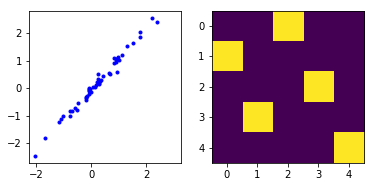

In [11]:
# ------------- Run ICA to get initial estimate of the embedding --------------
U_1, P = UhatICA(np.reshape(rMatFull,[Nr,T*Ns],order='F').T, Nx, U)[0:2]

plt.subplot(1,2,1)
plt.plot(U.flatten(),np.dot(U_1,P).flatten(),'b.')
plt.axis('square')
plt.subplot(1,2,2)
plt.imshow(P)
plt.show()

In [12]:
# Pick T such that we have a total of 500 samples
TTotal = 500
T = TTotal//Ns

rMatFull = rMatFull[:,0:T,:]
hMatFull = hMatFull[:,0:T,:]
xMatFull = xMatFull[:,0:T+1,:]


# ---------  Run the particle filter with true values of (U, J, G) --------
K = 100

x_truedec = np.zeros([Nx,T+1,Ns])
P_truedec = np.zeros([Nx,K,T+1,Ns])
r_truedec = np.zeros([Nr,T,Ns])
W_truedec = np.zeros([K,Ns])
LL        = np.zeros([Ns]) # Log likelihood 

for s in range(Ns):
    LL[s],x_truedec[:,:,s], P_truedec[:,:,:,s], W_truedec[:,s] = particlefilter(rMatFull[:,:,s], hMatFull[:,:,s], K, Qpr, Qobs, theta, nltype)
    r_truedec[:,:,s] = np.dot(U,x_truedec[:,1:,s])


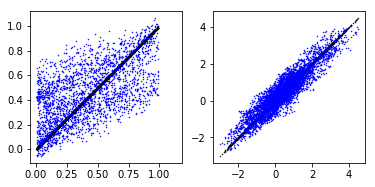

In [13]:
# ----------- Now we try to learn the parameters from data using PF-EM ----

lam_1 = np.array([0.25])
J_1 = Create_J(Nx, sp_J, 'Jtype', sc_J) # Coupling matrix
G_1 = 0.1*np.random.randn(5)   
V_1 = np.linalg.svd(np.random.randn(Nx,Nh), full_matrices=False)[2] # input embedding matrix


x_1 = np.zeros([Nx,T+1,Ns])
r_1 = np.zeros([Nr,T,Ns])
P_1 = np.zeros([Nx,K,T+1,Ns])
W_1 = np.zeros([K,Ns])
L_1 = np.zeros([Ns])

theta_1 = np.concatenate([lam_1, G_1, JMatToVec(J_1), U_1.flatten('F'), V_1.flatten('F') ])


for s in range(Ns):
    L_1[s],x_1[:,:,s], P_1[:,:,:,s], W_1[:,s] = particlefilter(rMatFull[:,:,s], hMatFull[:,:,s], K, Qpr, Qobs, theta_1, nltype)
    r_1[:,:,s] = np.dot(U_1,x_1[:,1:,s])
    
st = 6 #

plt.subplot(1,2,1)
plt.plot(xMatFull[:,st:,:].flatten(),x_truedec[:,st:,:].flatten(),'k.',markersize=1)
plt.plot(xMatFull[:,st:,:].flatten(), np.dot(P.T,np.reshape(x_1[:,st:,:],[Nx,Ns*(T+1-st)])).flatten(),'b.',markersize=1)
plt.axis('square')
plt.subplot(1,2,2)
plt.plot(rMatFull[:,st:,:].flatten(),r_truedec[:,st:,:].flatten(),'k.',markersize=1)
plt.plot(rMatFull[:,st:,:].flatten(),r_1[:,st:,:].flatten(),'b.',markersize=1)
plt.axis('square')
plt.show()


xinit = x_1
rinit = r_1

Jinit = J_1
Ginit = G_1
Uinit = U_1
Vinit = V_1
lam_init = lam_1

del x_truedec, r_truedec, P_truedec, W_truedec

In [14]:
# Running the EM algorithm

# Initialize the batch
idx     = np.random.randint(Ns)
rB      = rMatFull[:,:,idx] # pick the observations for the mini batch
hB      = hMatFull[:,:,idx]
P_B     = P_1[:,:,:,idx]
W_B     = W_1[:,idx]

EMIters = 50
LMat   = np.zeros([EMIters])

computegrad = np.array([1,1,0,1,0],dtype=int)


for iterem in range(EMIters):
    
    if iterem == EMIters//5:
        computegrad = [1, 1, 1, 1, 0]

    print(iterem, '..')  
    
    MStep = optimize.minimize(NegLL, theta_1, args = (rB, hB, P_B, W_B, Qpr, Qobs, nltype, computegrad), method='BFGS', jac = NegLL_D, options={'disp': False,'maxiter':100})
    theta_1 = MStep.x
        
    # Pick a new batch and run the particle filter with the updated parameters
    
    idx     = np.random.randint(Ns)
    rB      = rMatFull[:,:,idx] # pick the observations for the mini batch
    hB      = hMatFull[:,:,idx]
    
    LMat[iterem], x_B, P_B, W_B = particlefilter(rB, hB, K, Qpr, Qobs, theta_1, nltype)
    

# Extract parameters
lam_1, G_1, J_1, U_1, V_1 = extractParams(theta_1, 5, Nx, Nh, Nr)

# Run the PF with new parameters on all the batches
for s in range(Ns):
    L_1[s],x_1[:,:,s], P_1[:,:,:,s], W_1[:,s] = particlefilter(rMatFull[:,:,s], hMatFull[:,:,s], K, Qpr, Qobs, theta_1, nltype)
    r_1[:,:,s] = np.dot(U_1,x_1[:,1:,s])

0 ..
1 ..
2 ..
3 ..
4 ..
5 ..
6 ..
7 ..
8 ..
9 ..
10 ..
11 ..
12 ..
13 ..
14 ..
15 ..
16 ..
17 ..
18 ..
19 ..
20 ..
21 ..
22 ..
23 ..
24 ..
25 ..
26 ..
27 ..
28 ..
29 ..
30 ..
31 ..
32 ..
33 ..
34 ..
35 ..
36 ..
37 ..
38 ..
39 ..
40 ..
41 ..
42 ..
43 ..
44 ..
45 ..
46 ..
47 ..
48 ..
49 ..


Ghat = [-2.25334826 -0.6645798  -1.43260025 -2.32970621  2.25044116]


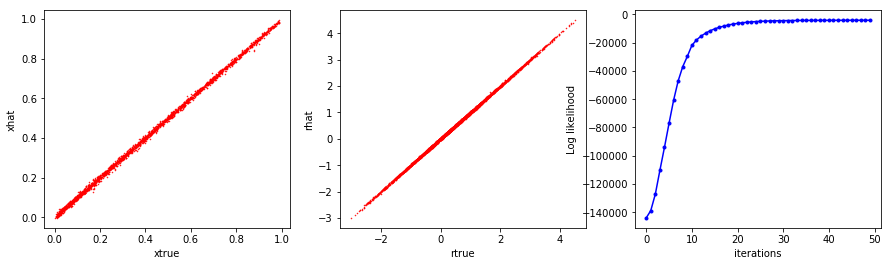

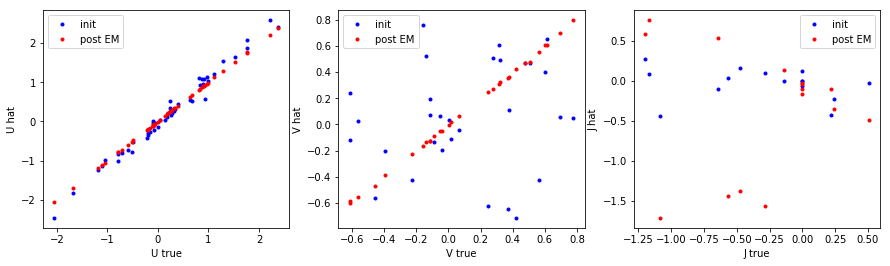

In [16]:
# Plotting results

print('Ghat =', G_1)

fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].plot(xMatFull[:,st:,:].flatten(), np.dot(P.T,np.reshape(x_1[:,st:,:],[Nx,Ns*(T+1-st)])).flatten(),'r.',markersize=1)
ax[0].set(xlabel='xtrue', ylabel='xhat')
ax[1].plot(rMatFull[:,st:,:].flatten(),r_1[:,st:,:].flatten(),'r.',markersize=1)
ax[1].set(xlabel='rtrue', ylabel='rhat')
ax[2].plot(np.arange(EMIters),LMat,'b.-')
ax[2].set(xlabel='iterations', ylabel='Log likelihood')
plt.show()

Jhat = J_1*0
Jinit_s = Jinit*0 # shuffle Jinit also
x_idx = np.dot(P.T,np.arange(Nx))

for ii in range(Nx):
    for jj in range(Nx):
        Jhat[ii,jj] = J_1[np.int(x_idx[ii]),np.int(x_idx[jj])]
        Jinit_s[ii,jj] = Jinit[np.int(x_idx[ii]),np.int(x_idx[jj])]
                          

fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(U.flatten(),np.dot(Uinit,P).flatten(),'b.')
ax[0].plot(U.flatten(),np.dot(U_1,P).flatten(),'r.')
ax[0].set(xlabel='U true', ylabel='U hat')
ax[0].legend(['init', 'post EM'])

ax[1].plot(V.flatten(),np.dot(P.T,Vinit).flatten(),'b.')
ax[1].plot(V.flatten(),np.dot(P.T,V_1).flatten(),'r.')
ax[1].set(xlabel='V true', ylabel='V hat')
ax[1].legend(['init', 'post EM'])

ax[2].plot(JMatToVec(J),JMatToVec(Jinit_s),'b.')
ax[2].plot(JMatToVec(J),JMatToVec(Jhat),'r.')
ax[2].set(xlabel='J true', ylabel='J hat')
ax[2].legend(['init', 'post EM'])
plt.show()

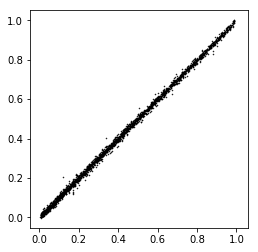

In [30]:
# run dynamics with new set of parameters and compare
xMatFull_1 = np.zeros([Nx,T+1,Ns])
for s in range(Ns):
    xMatFull_1[:,:,s] = runTAP(x0Full[:,s], hMatFull[:,:,s], Qpr, Qobs, theta_1, nltype)[0]

st = 5
plt.plot(xMatFull[:,st:,:].flatten(), np.dot(P.T,np.reshape(xMatFull_1[:,st:,:],[Nx,Ns*(T-st+1)])).flatten(),'k.',markersize=1)
plt.axis('square')
plt.show()